In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
#!pip install --upgrade category_encoders

In [3]:
# code from https://github.com/sshreyas999/Credit-Card-Clustering-PCA-Kmeans/blob/main/Credit%20Card%20Clustering%20(PCA%20%2B%20Kmeans).ipynb
from sklearn.preprocessing import StandardScaler, normalize, OneHotEncoder
from sklearn.decomposition import PCA  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Reading the data from the credit_date_df dataset created from the original dataset by converting the portfolio id into date format and extracted the year, month from the converted date field

In [4]:
ccfullData = pd.read_csv('credit_date_df.csv', header=0, index_col=0)
ccfullData.head()

,year,month,product_term_credit_limit,NP,cash_intent,ALJ0300,ALJ0316,ALJ0416,ALJ5030,ALJ5320,...,TSTU0910,TSTU2906,TSTU2907,TSTU2908,TSTU3906,TSTU3907,TSTU3908,TSTU4906,TSTU4907,TSTU4908
record_nb,,,,,,,,,,,,,,,,,,,,,
1,2019,8,500,0,0,2,1,1,33521,50283,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019,8,500,0,0,0,98,98,999999998,999999998,...,999999998.0,98.0,999999998.0,999999998.0,98.0,999999998.0,999999998.0,98.0,999999998.0,999999998.0
3,2019,8,500,0,0,1,0,0,999999997,999999997,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019,8,500,0,0,0,98,98,999999998,999999998,...,999999998.0,98.0,999999998.0,999999998.0,98.0,999999998.0,999999998.0,98.0,999999998.0,999999998.0
5,2019,8,500,0,1,2,0,0,999999997,999999997,...,999999998.0,98.0,999999998.0,999999998.0,98.0,999999998.0,999999998.0,98.0,999999998.0,999999998.0


In [5]:
x_a = ccfullData.loc[:, ccfullData.columns!='NP']
y_a = ccfullData.loc[:, ccfullData.columns =='NP']

#### Label Encoding

All the credit bureau attributes are continuous numeric values that have an infinite number of values between any two values(described as 'valid values' in the Experian Data dictionary). The numeric values are encoded into categorical groups to make better classification

In [6]:
le = LabelEncoder()

In [7]:
def convert_num_to_cat(data,x):
    data[x] = data[x].astype('category')
    data[x].fillna( method ='ffill', inplace = True) #filling na values
    le.fit(data[x])
    return le.transform(data[x])

In [8]:
x_b = x_a.drop(['year','month','product_term_credit_limit','cash_intent','ALL9950','ALL9951','GLBDECS','ALL6310','ALL6320','MTF6326'],axis=1)

In [9]:
x_b.head()

,ALJ0300,ALJ0316,ALJ0416,ALJ5030,ALJ5320,ALJ5730,ALJ5820,ALJ5830,ALJ8120,ALJ8220,...,TSTU0910,TSTU2906,TSTU2907,TSTU2908,TSTU3906,TSTU3907,TSTU3908,TSTU4906,TSTU4907,TSTU4908
record_nb,,,,,,,,,,,,,,,,,,,,,
1,2,1,1,33521,50283,0,698,698,6,42,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,98,98,999999998,999999998,999999998,999999998,999999998,9998,9998,...,999999998.0,98.0,999999998.0,999999998.0,98.0,999999998.0,999999998.0,98.0,999999998.0,999999998.0
3,1,0,0,999999997,999999997,999999997,999999997,999999997,89,89,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,98,98,999999998,999999998,999999998,999999998,999999998,9998,9998,...,999999998.0,98.0,999999998.0,999999998.0,98.0,999999998.0,999999998.0,98.0,999999998.0,999999998.0
5,2,0,0,999999997,999999997,999999997,999999997,999999997,65,77,...,999999998.0,98.0,999999998.0,999999998.0,98.0,999999998.0,999999998.0,98.0,999999998.0,999999998.0


In [10]:
for x in x_b.iloc[:,:-1]:
    x_b[x +'_cat'] = convert_num_to_cat(x_b,x)

Nominal variables (e.g. year, month, product term credit limit, cash intent) and few credit bureau attributes which have units of Flag, rank are categorical which needs converting to numerical prior to modelling. **One Hot Encoder** is used which basically creates n columns as n unique categories within that variable and assigns 0 or 1 depending on the absence/presence of each category in each column.<br>
One Hot Encoder was designed to keep the consistency in the number of categories across train and test sets (e.g. handling categories that do not appear in either) with “handle_unknown= “error”. To reduce the *multicollinearity*, the parameter of “drop= ‘first’” which helps remove one of the sub-variables after encoding

In [11]:
#code adopted from https://towardsdatascience.com/credit-risk-management-eda-feature-engineering-81cc34efc428
#ignore tells the encoder to ignore new categories in the test set by encoding them with 0's
onehot = OneHotEncoder(sparse=False, drop= 'first', handle_unknown = 'error') 

onehot.fit(x_a.year.to_numpy().reshape(-1,1))
year_onehot = onehot.transform(x_a.year.to_numpy().reshape(-1,1))
year_onehot = pd.DataFrame(year_onehot, columns= onehot.get_feature_names(['year']))

onehot.fit(x_a.month.to_numpy().reshape(-1,1))
month_onehot = onehot.transform(x_a.month.to_numpy().reshape(-1,1))
month_onehot = pd.DataFrame(month_onehot, columns= onehot.get_feature_names(['month']))

onehot.fit(x_a.product_term_credit_limit.to_numpy().reshape(-1,1))
product_term_onehot = onehot.transform(x_a.product_term_credit_limit.to_numpy().reshape(-1,1))
product_term_onehot = pd.DataFrame(product_term_onehot, columns= onehot.get_feature_names(['product_term_credit_limit']))

onehot.fit(x_a.cash_intent.to_numpy().reshape(-1,1))
cash_intent_onehot = onehot.transform(x_a.cash_intent.to_numpy().reshape(-1,1))
cash_intent_onehot = pd.DataFrame(cash_intent_onehot, columns= onehot.get_feature_names(['cash_intent']))

#Credit bureau attributes with Flag unit
onehot.fit(x_a.ALL9950.to_numpy().reshape(-1,1))
ALL9950_onehot = onehot.transform(x_a.ALL9950.to_numpy().reshape(-1,1))
ALL9950_onehot = pd.DataFrame(ALL9950_onehot, columns= onehot.get_feature_names(['ALL9950']))

onehot.fit(x_a.ALL9951.to_numpy().reshape(-1,1))
ALL9951_onehot = onehot.transform(x_a.ALL9951.to_numpy().reshape(-1,1))
ALL9951_onehot = pd.DataFrame(ALL9951_onehot, columns= onehot.get_feature_names(['ALL9951']))

onehot.fit(x_a.GLBDECS.to_numpy().reshape(-1,1))
GLBDECS_onehot = onehot.transform(x_a.GLBDECS.to_numpy().reshape(-1,1))
GLBDECS_onehot = pd.DataFrame(GLBDECS_onehot, columns= onehot.get_feature_names(['GLBDECS']))

#Credit bureau attributes with Rank unit
onehot.fit(x_a.ALL6310.to_numpy().reshape(-1,1))
ALL6310_onehot = onehot.transform(x_a.ALL6310.to_numpy().reshape(-1,1))
ALL6310_onehot = pd.DataFrame(ALL6310_onehot, columns= onehot.get_feature_names(['ALL6310']))

onehot.fit(x_a.ALL6320.to_numpy().reshape(-1,1))
ALL6320_onehot = onehot.transform(x_a.ALL6320.to_numpy().reshape(-1,1))
ALL6320_onehot = pd.DataFrame(ALL6320_onehot, columns= onehot.get_feature_names(['ALL6320']))

onehot.fit(x_a.MTF6326.to_numpy().reshape(-1,1))
MTF6326_onehot = onehot.transform(x_a.MTF6326.to_numpy().reshape(-1,1))
MTF6326_onehot = pd.DataFrame(MTF6326_onehot, columns= onehot.get_feature_names(['MTF6326']))


In [12]:
concatenated_dataframes = pd.concat(
    [
        month_onehot.reset_index(drop=True),
        year_onehot.reset_index(drop=True),
        product_term_onehot.reset_index(drop=True),
        cash_intent_onehot.reset_index(drop=True),
        ALL9950_onehot.reset_index(drop=True),
        ALL9951_onehot.reset_index(drop=True),
        GLBDECS_onehot.reset_index(drop=True),
        ALL6310_onehot.reset_index(drop=True),
        ALL6320_onehot.reset_index(drop=True),
        MTF6326_onehot.reset_index(drop=True),
        x_b.iloc[:,2319:-1].reset_index(drop=True)
    ],
    axis=1,
    ignore_index=True,
)

concatenated_dataframes_columns = [
    list(month_onehot.columns),
    list(year_onehot.columns),
    list(product_term_onehot.columns),
    list(cash_intent_onehot.columns),
    list(ALL9950_onehot.columns),
    list(ALL9951_onehot.columns),
    list(GLBDECS_onehot.columns),
    list(ALL6310_onehot.columns),
    list(ALL6320_onehot.columns),
    list(MTF6326_onehot.columns),
    list(x_b.iloc[:,2319:-1].columns)
]
    
flatten = lambda nested_lists: [item for sublist in nested_lists for item in sublist]

concatenated_dataframes.columns = flatten(concatenated_dataframes_columns)

In [13]:
from sklearn import model_selection
from statistics import mean, stdev
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score,auc,roc_curve
import time

### Imbalanced Dataset

As this dataset is imbalanced/skewed towards one target variable '0', **Stratified K-Fold Cross Validation** technique is considered to mantain the ratio of each labels in a Fold (any K-1 Dataset) constant. Hence, each fold essentially has the same ratio of each labels.

In [16]:
#code from https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/#:~:text=Compare%20Machine%20Learning%20Algorithms%20Consistently%20The%20key%20to,the%20example%20below%206%20different%20algorithms%20are%20compared%3A

X = concatenated_dataframes
Y = y_a
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)
row_index = 0
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('XGBoost', XGBClassifier(eval_metric='mlogloss')))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

# Create StratifiedKFold object.    
tic = time.perf_counter()
for name, model in models:
    skfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=skfold, scoring=scoring)
    f1_results = model_selection.cross_val_score(model, X, Y, cv=skfold, scoring='f1')
    recall_results = model_selection.cross_val_score(model, X, Y, cv=skfold, scoring='recall')
    precision_results = model_selection.cross_val_score(model, X, Y, cv=skfold, scoring='precision')
    roc_auc_results = model_selection.cross_val_score(model, X, Y, cv=skfold, scoring='roc_auc')
    MLA_compare.loc[row_index,'MLA used'] = name
    MLA_compare.loc[row_index, 'Test Accuracy'] = round(mean(cv_results), 4)
    MLA_compare.loc[row_index, 'Precision'] = round(mean(precision_results),4)
    MLA_compare.loc[row_index, 'Recall'] = round(mean(recall_results),4)
    MLA_compare.loc[row_index, 'f1'] = mean(f1_results)
    MLA_compare.loc[row_index, 'roc_auc'] = mean(roc_auc_results)
    results.append(cv_results)
    names.append(name)
    # Print the output.
    print('List of possible accuracies for {0} is: {1}'.format(name, cv_results))
    print('List of possible Precision for {0} is: {1}'.format(name, precision_results))
    print('List of possible Recall for {0} is: {1}'.format(name, recall_results))
    print('List of possible F1 score for {0} is: {1}'.format(name, f1_results))
    print('List of possible ROC_AUC for {0} is: {1}'.format(name, roc_auc_results))
    msg = "%s: %f (%f)" % (name, mean(cv_results), cv_results.std())
    print(msg)
    toc = time.perf_counter()
    secs = toc - tic
    print("---Classifier %s use %0.4f seconds ---" %(name, secs))
    row_index+=1
    
MLA_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)    
MLA_compare


List of possible accuracies for Logistic Regression is: [0.90646348 0.90751445 0.91093011 0.90856542 0.90830268]
List of possible Precision for Logistic Regression is: [0.35897436 0.41463415 0.625      0.43478261 0.40909091]
List of possible Recall for Logistic Regression is: [0.04057971 0.04927536 0.04347826 0.02898551 0.02608696]
List of possible F1 score for Logistic Regression is: [0.07291667 0.0880829  0.08130081 0.05434783 0.04904632]
List of possible ROC_AUC for Logistic Regression is: [0.73546056 0.7495086  0.76066396 0.75760796 0.75311902]
Logistic Regression: 0.908355 (0.001481)
---Classifier Logistic Regression use 239.8962 seconds ---
List of possible accuracies for XGBoost is: [0.92459275 0.92538098 0.92380452 0.92485549 0.9224908 ]
List of possible Precision for XGBoost is: [0.71969697 0.72592593 0.72357724 0.76576577 0.67605634]
List of possible Recall for XGBoost is: [0.27536232 0.28405797 0.25797101 0.24637681 0.27826087]
List of possible F1 score for XGBoost is: [0.39

,MLA used,Test Accuracy,Precision,Recall,f1,roc_auc
1,XGBoost,0.9242,0.7222,0.2684,0.390811,0.823596
0,Logistic Regression,0.9084,0.4485,0.0377,0.069139,0.751272


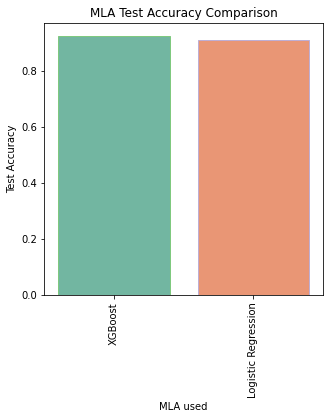

In [15]:
# Creating plot to show the train accuracy
plt.subplots(figsize=(5,5))
sns.barplot(x="MLA used", y="Test Accuracy",data=MLA_compare,palette='Set2',edgecolor=sns.color_palette('Accent',7))
plt.xticks(rotation=90)
plt.title('MLA Test Accuracy Comparison')
plt.show()